<a href="https://colab.research.google.com/github/recohut/notebooks/blob/main/nbs/P422159_Entire_item_space_exploration_with_Contextual_bandits_on_MIND_news_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entire item space exploration with Contextual bandits on MIND news dataset

## Executive summary

| | |
| --- | --- |
| Problem | Contextual bandit (CB) strive to make a good trade-off between exploration and exploitation so that users' potential interests have chances to expose. However, classical CB can only be applied to a small, sampled item set (usually hundreds), which forces the typical applications in recommender systems limited to candidate post-ranking, homepage top item ranking, ad creative selection, or online model selection (A/B test). |
| Solution | Hierarchical CB (HCB) to make classical CB model (such as LinUCB and Thompson Sampling) capable to explore users' interest in the entire item space without limiting it to a small item set. We first construct a hierarchy item tree via a bottom-up clustering algorithm to organize items in a coarse-to-fine manner. Then uses HCB to explore users' interest in the hierarchy tree. HCB takes the exploration problem as a series of decision-making processes, where the goal is to find a path from the root to a leaf node, and the feedback will be back-propagated to all the nodes in the path. For example, in e-commerce scenario, “Apparel > Clothing > Women’s Clothing > Dresses” is a path from general apparel to women’s dresses. Progressive hierarchical CB (pHCB) algorithm is an extension of HCB, which progressively extends visible nodes which reach a confidence level for exploration, to avoid misleading actions on upper-level nodes in the sequential decision-making process. Consequently, the pHCB avoids greedily selecting only one node at each level to improve the HCB. |
| Dataset | MIND |
| Preprocessing | We use Sentence BERT to train news embeddings from their contents, and adopt a GRU as the user model to fine-tune news embeddings from the sequence of click logs. Tree structure construction - to construct a tree structure with 𝐿 levels, at first, 𝑁 items are clustered into ⁍ different subsets based on the similarity of item embeddings. We treat each subset as a new node on the tree, with an embedding vector being the average of all item embeddings belonging to this node. Afterward, these ⁍ nodes will be further clustered into ⁍ different subsets using K-Means and each subset will be treated as a new node on the tree, forming a parent-children relation. This step will be repeated several times until the depth of the tree structure researches 𝐿. As a result, the constructed tree structure, denoted by H, contains ⁍ nodes at each level, where ⁍ = 1 because only a root node appears at the first level. Intuitively, items within the same node are more similar to each other, thus the clustering results reflect the dependencies among items. In H, only the root node does not have parent node, and leaf nodes have no children nodes. |
| Metrics | Cumulative reward. |

## Process flow

## HCB & pHCB model

### HCB model and training algorithm

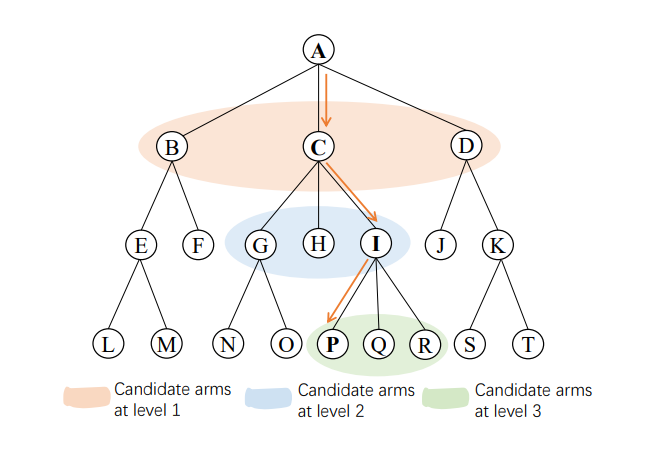

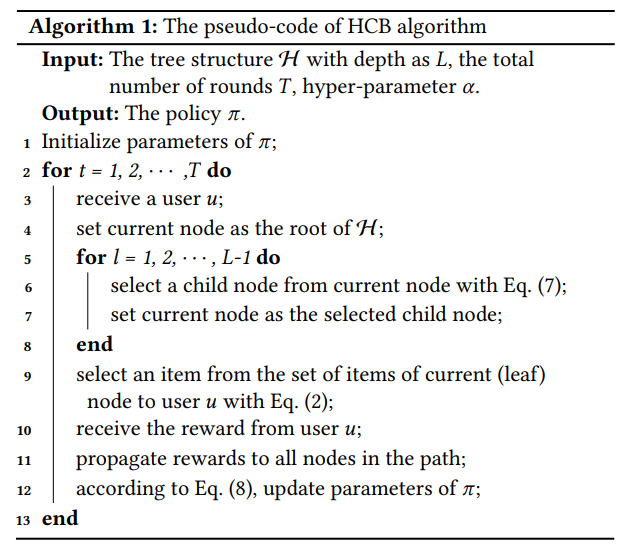

### pHCB model and training algorithm

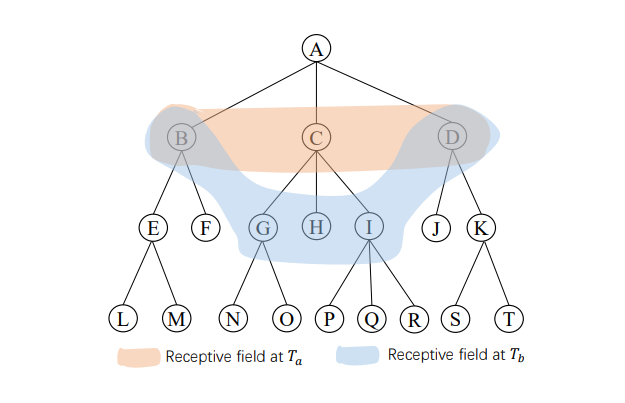

*An illustration of pHCB. At round $𝑇_𝑎$, the receptive field consists of nodes B, C and D; After several trials, at round $𝑇_𝑏$, node C meets the conditions of expansion, so the receptive field changes to nodes B, D, G, H and I.*

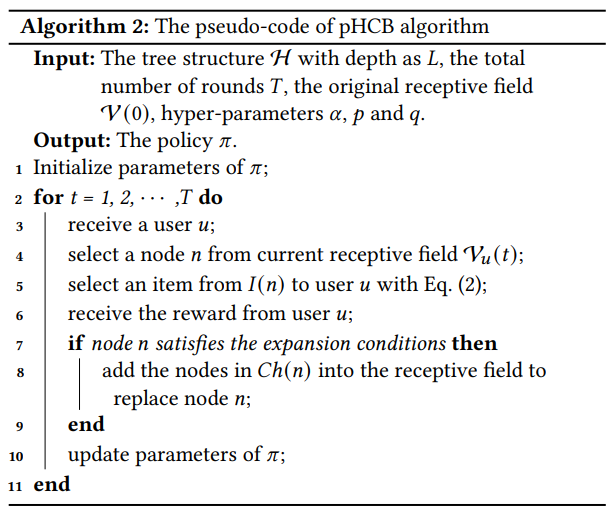

## Setup

In [1]:
!git clone --branch v1 https://github.com/RecoHut-Datasets/mind.git data

Cloning into 'data'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 2), reused 16 (delta 2), pack-reused 0
Unpacking objects: 100% (20/20), done.
Checking out files: 100% (10/10), done.


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import sys
import logging
import random
import pickle
from multiprocessing import Pool
import math
from collections import defaultdict
from datetime import datetime,timedelta

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
thread_num=20

In [22]:
class Params():
    def free_memory(self):
        for a in dir(self):
            if not a.startswith('__') and hasattr(getattr(self, a), 'free_memory'):
                getattr(self, a).free_memory()

def config():
    cfg = Params()

    cfg.dataset         = 'MIND' #TaoBao or MIND
    cfg.T               = 1000 #the number of rounds of each bandit algorithm
    cfg.k               = 1 #the number of items recommended to user at each round, default is 1
    cfg.activate_num    = 10 #the hyper-papamter p for pHCB
    cfg.activate_prob   = 0.1 #the hyper-papamter q for pHCB
    cfg.epsilon         = 0.05 #the epsilon value for greedy-based algorithms
    cfg.new_tree_file   = '1000_10_btree.pkl' #the tree file name
    cfg.noise_scale     = 0.001 #the standard deviation of environmental noise
    cfg.keep_prob       = 0.0001 #sample ratio; default is 1.0, which means testing all users
    cfg.linucb_para     = {'alpha': 0.5} #the hyper-parameters for linucb algorithm
    cfg.poolsize        = 50 #the size of candidate pool
    cfg.random_choice   = False #whether random choice an item to user

    return cfg

def log_config(cfg,logger):
    for key, value in cfg.__dict__.items():
        logger.info('{} : {}'.format(key,value))

cfg = config()

In [16]:
def get_timestamp():
    # return datetime.now().strftime('%y%m%d-%H%M%S')
    return (datetime.now()+timedelta(days=1/3)).strftime('%y%m%d-%H%M%S')

def setup_logger(logger_name, phase, level=logging.INFO, screen=False, tofile=False):
    '''set up logger'''
    lg = logging.getLogger(logger_name)
    formatter = logging.Formatter('%(asctime)s.%(msecs)03d - %(levelname)s: %(message)s',
                                  datefmt='%y-%m-%d %H:%M:%S')
    lg.setLevel(level)
    root = './logger/'
    time_now = get_timestamp()
    if tofile:
        log_file = os.path.join(root, phase + '_{}.log'.format(time_now))
        fh = logging.FileHandler(log_file, mode='w')
        fh.setFormatter(formatter)
        lg.addHandler(fh)
    if screen:
        sh = logging.StreamHandler()
        sh.setFormatter(formatter)
        lg.addHandler(sh)
    return time_now

## LinUCB

### Items

In [9]:
class Item():
    def __init__(self,gid,x1,x2,bias,para={}):
        self.gid     = gid
        self.fv      = {} #feature vector for training/simulator
        self.fv['t'] = x1 #training
        self.fv['s'] = x2 #simulator
        self.fv['b'] = bias #bias
        self.para    = para #other info

class ItemManager():
    def __init__(self,path):
        self.path    = path
        self.items   = {}
        self.n_items = 0

    def load_items(self):
        item_info = pickle.load(open(self.path,'rb'))
        for key,j_s in item_info.items():
            gid = j_s['gid']
            x1  = j_s['x1']
            x2  = j_s['x2']
            bias= j_s['bias']
            para = {}
            para['category2'] = j_s['category2']
            self.items[gid] = Item(gid,x1,x2,bias,para)
        self.n_items=len(self.items)

### Users

In [10]:
class User():
    def __init__(self,uid,x1,x2,bias,para={}):
        self.uid     = uid
        self.fv      = {} #feature vector for training/simulator
        self.fv['t'] = x1 # training
        self.fv['s'] = x2 # simulator
        self.fv['b'] = bias # simulator bias
        self.para    = para #other info

class UserManager():
    def __init__(self,path):
        self.path    = path
        self.users   = {}
        self.n_users = 0

    def load_users(self):
        user_info = pickle.load(open(self.path,'rb'))
        for key,j_s in user_info.items():
            if np.random.random()>cfg.keep_prob:
                continue
            uid = j_s['uid']
            x1  = j_s['x1']
            x2  = j_s['x2']
            bias= j_s['bias']
            self.users[uid] = User(uid,x1,x2,bias)
        self.n_users=len(self.users)

### Naive LinUCB

In [26]:
class LinUCBUserStructNLUCB():
    def __init__(self,uid,dim,init,alpha):
        self.uid = uid
        self.dim = dim
        self.A = np.identity(n=self.dim)
        self.Ainv = np.linalg.inv(self.A)
        self.b = np.zeros((self.dim))  
        if init!='zero':
            self.theta = np.random.rand(self.dim)
        else:
            self.theta = np.zeros(self.dim)
        self.alpha = alpha # store the new alpha calcuated in each iteratioin

    def getProb(self,fv):
        if self.alpha==-1:
            raise AssertionError
        mean=np.dot(self.theta.T,fv)
        var=np.sqrt(np.dot(np.dot(fv.T,self.Ainv),fv))
        pta=mean+self.alpha*var
        return pta

    def getInv(self, old_Minv, nfv):
        # new_M=old_M+nfv*nfv'
        # try to get the inverse of new_M
        tmp_a=np.dot(np.outer(np.dot(old_Minv,nfv),nfv),old_Minv)
        tmp_b=1+np.dot(np.dot(nfv.T,old_Minv),nfv)
        new_Minv=old_Minv-tmp_a/tmp_b
        return new_Minv

    def updateParameters(self, a_fv, reward):
        self.A+=np.outer(a_fv, a_fv)
        self.b+=a_fv*reward
        self.Ainv=self.getInv(self.Ainv,a_fv)
        self.theta=np.dot(self.Ainv, self.b)


class NaiveLinUCB():
    def __init__(self,para,init='zero'):
        self.init=init
        self.users={}
        try:
            self.alpha=para['alpha']
        except:
            self.alpha=-1

    def decide(self,uid,arms):
        try:
            user=self.users[uid]
        except:
            dim = arms[0].fv['t'].shape[0]
            self.users[uid]=LinUCBUserStructNLUCB(uid,dim,"zero",self.alpha)
            user=self.users[uid]
        aid = None
        max_r = float('-inf')
        for index,arm in enumerate(arms):
            #each item is an arm
            reward = user.getProb(arm.fv['t'])
            if reward>max_r:
                aid = index
                max_r = reward
        arm_picker = arms[aid]
        return arm_picker


    def updateParameters(self, picked_arm, reward, uid):
        self.users[uid].updateParameters(picked_arm.fv['t'],reward)

### HCB

In [27]:
class LinUCBBaseStruct():
    def __init__(self,dim,init,alpha):
        self.dim = dim
        self.A = np.identity(n=self.dim)
        self.Ainv = np.linalg.inv(self.A)
        self.b = np.zeros((self.dim))  
        if init!='zero':
            self.theta = np.random.rand(self.dim)
        else:
            self.theta = np.zeros(self.dim)
        self.alpha = alpha # store the new alpha calcuated in each iteratioin

    def getProb(self,fv):
        if self.alpha==-1:
            raise AssertionError
        mean=np.dot(self.theta.T,fv)
        var=np.sqrt(np.dot(np.dot(fv.T,self.Ainv),fv))
        pta=mean+self.alpha*var
        return pta

    def getInv(self, old_Minv, nfv):
        # new_M=old_M+nfv*nfv'
        # try to get the inverse of new_M
        tmp_a=np.dot(np.outer(np.dot(old_Minv,nfv),nfv),old_Minv)
        tmp_b=1+np.dot(np.dot(nfv.T,old_Minv),nfv)
        new_Minv=old_Minv-tmp_a/tmp_b
        return new_Minv

    def updateParameters(self, a_fv, reward):
        self.A+=np.outer(a_fv, a_fv)
        self.b+=a_fv*reward
        self.Ainv=self.getInv(self.Ainv,a_fv)
        self.theta=np.dot(self.Ainv, self.b)


class LinUCBUserStructHCB():
    def __init__(self,uid,root,dim,init,alpha):
        self.uid = uid
        self.root = root
        self.base_linucb = {}
        self.path = []
        if not cfg.random_choice:
            self.linucb = NaiveLinUCB(cfg.linucb_para)


class HCB():
    def __init__(self,para,init='zero',root=None):
        self.init=init
        self.users={}
        try:
            self.alpha=para['alpha']
        except:
            self.alpha=-1
        self.root = root
        self.total_depth = len(cfg.new_tree_file.split('_'))-1


    def decide(self,uid,root=None):
        try:
            user=self.users[uid]
        except:
            self.dim = self.root.emb.shape[0]
            self.users[uid]=LinUCBUserStructHCB(uid,self.root,self.dim,"zero",self.alpha)
            user=self.users[uid]
        current_node = user.root
        depth = 0
        user.path = []
        while(current_node.is_leaf==False):
            children = current_node.children
            max_r = float('-inf')
            aid = None
            if depth not in user.base_linucb:
                user.base_linucb[depth] = LinUCBBaseStruct(self.dim,"zero",self.alpha)
            poolsize = int(cfg.poolsize/self.total_depth)
            if len(children)<=poolsize:
                arms = children
            else:
                aids = np.random.choice(len(children),poolsize,replace=False)
                arms = [children[i] for i in aids]
            for index,arm in enumerate(arms):
                reward = user.base_linucb[depth].getProb(arm.emb)
                if reward>max_r:
                    aid = index
                    max_r = reward
            arm_picker = arms[aid]
            user.path.append(arm_picker)
            current_node = arm_picker
            depth += 1
        return arm_picker,aid

    def update(self,uid,aid,arm_picker,item,feedback):
        user = self.users[uid]
        path = user.path
        assert len(path)!=0
        for i,arm_picker in enumerate(path):
            depth = i
            user.base_linucb[depth].updateParameters(arm_picker.emb,feedback)

### pHCB

In [32]:
class ArmStructPHCB():
    def __init__(self,arm,depth):
        self.arm = arm
        self.gids = arm.gids
        self.depth = depth # only when arm is a tree node
        self.itemclick = defaultdict(bool)
        self.feedback = defaultdict(float)
        self.vv = defaultdict(int)

    def expand(self):
        if (sum(self.vv.values()))<cfg.activate_num*np.log(self.depth):
            return False
        if (sum(self.feedback.values())/sum(self.vv.values()))<cfg.activate_prob*np.log(self.depth):
            return False
        return True

class LinUCBUserStructPHCB():
    def __init__(self,uid,arms,dim,init,alpha):
        self.uid = uid
        self.arms = arms
        self.dim = dim
        self.A = np.identity(n=self.dim)
        self.Ainv = np.linalg.inv(self.A)
        self.b = np.zeros((self.dim))  
        if init!='zero':
            self.theta = np.random.rand(self.dim)
        else:
            self.theta = np.zeros(self.dim)
        self.alpha = alpha # store the new alpha calcuated in each iteratioin
        if not cfg.random_choice:
            self.linucb = NaiveLinUCB(cfg.linucb_para)



    def getProb(self,fv):
        if self.alpha==-1:
            raise AssertionError
        mean=np.dot(self.theta.T,fv)
        var=np.sqrt(np.dot(np.dot(fv.T,self.Ainv),fv))
        pta=mean+self.alpha*var
        return pta

    def getInv(self, old_Minv, nfv):
        # new_M=old_M+nfv*nfv'
        # try to get the inverse of new_M
        tmp_a=np.dot(np.outer(np.dot(old_Minv,nfv),nfv),old_Minv)
        tmp_b=1+np.dot(np.dot(nfv.T,old_Minv),nfv)
        new_Minv=old_Minv-tmp_a/tmp_b
        return new_Minv

         
    def updateParameters(self, a_fv, reward):
        self.A+=np.outer(a_fv, a_fv)
        self.b+=a_fv*reward
        self.Ainv=self.getInv(self.Ainv,a_fv)
        self.theta=np.dot(self.Ainv, self.b)


class pHCB():
    def __init__(self,para,init='zero',root=None):
        self.init=init
        self.users={}
        try:
            self.alpha=para['alpha']
        except:
            self.alpha=-1
        self.root = root

    def decide(self,uid,root=None):
        try:
            user=self.users[uid]
        except:
            arms = []
            root = self.root
            for node in root.children:
                arms.append(ArmStructPHCB(node,2))
            dim = root.emb.shape[0]
            self.users[uid]=LinUCBUserStructPHCB(uid,arms,dim,"zero",self.alpha)
            user=self.users[uid]
        aid = None
        max_r = float('-inf')
        if len(user.arms)<=cfg.poolsize:
            aids = list(range(len(user.arms)))
        else:
            aids = np.random.choice(len(user.arms),cfg.poolsize,replace=False)
        for index in aids:
            arm = user.arms[index]
            depth = arm.depth
            reward = user.getProb(arm.arm.emb)*depth
            if reward>max_r:
                aid = index
                max_r = reward
        arm_picker = user.arms[aid]
        return arm_picker,aid


    def updateParameters(self, picked_arm, reward, uid):
        self.users[uid].updateParameters(picked_arm.arm.emb,reward)

    def update(self,uid,aid,arm_picker,item,feedback):
        gid = item.gid
        arm_picker.feedback[gid] += feedback
        arm_picker.vv[gid] += 1
        arm_picker.itemclick[gid] = True
        user = self.users[uid]
        self.updateParameters(arm_picker,feedback,uid)
        if arm_picker.expand() and arm_picker.arm.is_leaf==False:
            depth = arm_picker.depth+1
            user.arms.pop(aid)
            for node in arm_picker.arm.children:
                arm = ArmStructPHCB(node,depth)
                for gid in arm.gids:
                    arm.itemclick[gid]=arm_picker.itemclick[gid]
                    arm.feedback[gid]=arm_picker.feedback[gid]
                    arm.vv[gid]=arm_picker.vv[gid]
                user.arms.append(arm)

### CLinUCB

In [33]:
class ArmStructCLUCB():
    def __init__(self,arm):
        self.arm = arm
        self.gids = arm.gids

class LinUCBUserStructCLUCB():
    def __init__(self,uid,arms,dim,init,alpha):
        self.uid = uid
        self.arms = arms
        self.dim = dim
        self.A = np.identity(n=self.dim)
        self.Ainv = np.linalg.inv(self.A)
        self.b = np.zeros((self.dim))  
        if init!='zero':
            self.theta = np.random.rand(self.dim)
        else:
            self.theta = np.zeros(self.dim)
        self.alpha = alpha # store the new alpha calcuated in each iteratioin
        if not cfg.random_choice:
            self.linucb = NaiveLinUCB(cfg.linucb_para)



    def getProb(self,fv):
        if self.alpha==-1:
            raise AssertionError
        mean=np.dot(self.theta.T,fv)
        var=np.sqrt(np.dot(np.dot(fv.T,self.Ainv),fv))
        pta=mean+self.alpha*var
        return pta

    def getInv(self, old_Minv, nfv):
        # new_M=old_M+nfv*nfv'
        # try to get the inverse of new_M
        tmp_a=np.dot(np.outer(np.dot(old_Minv,nfv),nfv),old_Minv)
        tmp_b=1+np.dot(np.dot(nfv.T,old_Minv),nfv)
        new_Minv=old_Minv-tmp_a/tmp_b
        return new_Minv

         
    def updateParameters(self, a_fv, reward):
        self.A+=np.outer(a_fv, a_fv)
        self.b+=a_fv*reward
        self.Ainv=self.getInv(self.Ainv,a_fv)
        self.theta=np.dot(self.Ainv, self.b)


class CLinUCB():
    def __init__(self,para,arms,init='zero'):
        self.init=init
        self.users={}
        self.arms = [ArmStructCLUCB(arm) for arm in arms]
        try:
            self.alpha=para['alpha']
        except:
            self.alpha=-1

    def decide(self,uid):
        try:
            user=self.users[uid]
        except:
            dim = self.arms[0].arm.emb.shape[0]
            self.users[uid]=LinUCBUserStructCLUCB(uid,self.arms,dim,"zero",self.alpha)
            user=self.users[uid]
        aid = None
        max_r = float('-inf')
        if len(user.arms)<=cfg.poolsize:
            arms = user.arms
        else:
            aids = np.random.choice(len(user.arms),cfg.poolsize,replace=False)
            arms = [user.arms[i] for i in aids]
        for index,arm in enumerate(arms):
            reward = user.getProb(arm.arm.emb)
            if reward>max_r:
                aid = index
                max_r = reward
        arm_picker = arms[aid]
        return arm_picker,aid


    def updateParameters(self, picked_arm, reward, uid):
        self.users[uid].updateParameters(picked_arm.arm.emb,reward)

    def update(self,uid,aid,arm_picker,item,feedback):
        self.updateParameters(arm_picker,feedback,uid)

### Simulation

In [17]:
dir_path = './data/'
logger_name = cfg.dataset+'-'+'simulator_multi_process_linucb'
os.makedirs('./logger', exist_ok=True)
time_now = setup_logger('simulator_multi_process', logger_name, level=logging.INFO, screen=True, tofile=True)
logger = logging.getLogger('simulator_multi_process')

In [30]:
class Tree():
    def __init__(self):
        self.emb         = None
        self.size        = 0
        self.gids        = []
        self.children    = None
        self.is_leaf     = False

class simulateExp():
    def __init__(self,users,items,tree,out_folder,test_iter):
        self.users = users
        self.items = items
        self.tree  = tree
        self.out_folder = out_folder
        self.test_iter = test_iter

    def noise(self):
        return np.random.normal(scale=cfg.noise_scale)

    def get_feedback(self,uid,gid):
        user = self.users[uid]
        item = self.items[gid]
        x = np.dot(user.fv['s'],item.fv['s']) + user.fv['b'] + item.fv['b']
        return 1/(1+np.exp(-x))

    def get_candidatePool(self):
        gids = list(self.items.keys())
        select_gids = np.random.choice(gids,cfg.poolsize, replace=False)
        arms = []
        for gid in select_gids:
            arms.append(self.items[gid])
        return arms


    def get_leafNodes(self,root):
        # current = [self.tree]
        current = [root]
        leafNodes = []
        while(len(current)>0):
            temp = []
            for node in current:
                if node.is_leaf:
                    leafNodes.append(node)
                else:
                    temp += node.children
            current = temp
        return leafNodes


    def get_categoryNodes(self):
        items = self.items
        categoryNodes = {}
        for gid in items:
            item = items[gid]
            category = item.para['category2']
            if category not in categoryNodes:
                categoryNodes[category] = Tree()
            categoryNodes[category].gids.append(gid)
        res = []
        for _,node in categoryNodes.items():
            x = []
            for gid in node.gids:
                x.append(items[gid].fv['t'])
            x = np.array(x)
            emb = np.mean(x,0)
            node.emb = emb
            res.append(node)
        return res


    def simulationPerUser(self,user,iters):
        process_id=os.getpid()
        print('[simulationPerUser] uid: %d, process_id: %d'%(user.uid, process_id))
        user_reward={}
        for iter_ in range(iters):
            cur_iter_noise = self.noise()
            user_reward[iter_] = {}
            for algname,alg in algorithms.items():
                if algname in ['naive_linucb']:
                    arms = self.get_candidatePool()
                    arm_picker = alg.decide(user.uid,arms)
                    feedback = self.get_feedback(user.uid,arm_picker.gid)
                    alg.updateParameters(arm_picker,feedback,user.uid)
                    user_reward[iter_][algname] = feedback
                    continue
                else:
                    arm_picker,aid = alg.decide(user.uid)
                if cfg.random_choice:
                    replace = True if len(arm_picker.gids)<cfg.k else False
                    gids = np.random.choice(arm_picker.gids,cfg.k,replace=replace)
                    all_feedback = 0
                    for gid in gids:
                        feedback = self.get_feedback(user.uid,gid)
                        alg.update(user.uid,aid,arm_picker,gid,feedback)
                        all_feedback += feedback
                    avg_feedback = all_feedback/len(gids)
                    user_reward[iter_][algname] = avg_feedback
                else:
                    if len(arm_picker.gids)<=cfg.poolsize:
                        arms = [self.items[gid] for gid in arm_picker.gids]
                    else:
                        arms = [self.items[gid] for gid in np.random.choice(arm_picker.gids,cfg.poolsize,replace=False).tolist()]
                    item = alg.users[user.uid].linucb.decide(user.uid,arms)
                    feedback = self.get_feedback(user.uid,item.gid)
                    alg.update(user.uid,aid,arm_picker,item,feedback)
                    alg.users[user.uid].linucb.updateParameters(item,feedback,user.uid)
                    user_reward[iter_][algname] = feedback
        return user_reward

    def run_algorithms(self,algorithms):
        print('run algorithms')
        pool= Pool(processes=thread_num)
        results=[]
        for uid, user in self.users.items():
            result=pool.apply_async(self.simulationPerUser,(user,self.test_iter))
            results.append(result)
        pool.close()
        pool.join()
        all_user_reward=[]
        for result in results:
            tmp_reward=result.get()
            all_user_reward.append(tmp_reward)

        AlgReward = {}
        for algname in algorithms:
            AlgReward[algname] = []

        for iter_ in range(self.test_iter):
            iter_avg_reward = {}
            for algname in algorithms:
                iter_avg_reward[algname] = 0
            for user_reward in all_user_reward:
                for algname in user_reward[iter_]:
                    iter_avg_reward[algname] += user_reward[iter_][algname]
            for algname in algorithms:
                AlgReward[algname].append(iter_avg_reward[algname]/len(all_user_reward))
        for algname in algorithms:
            AlgReward[algname] = np.cumsum(AlgReward[algname])
        return AlgReward

In [34]:
if __name__ == '__main__':
    Users = UserManager(dir_path + '/user_info.pkl')
    Items = ItemManager(dir_path + '/item_info.pkl')
    root = pickle.load(open(dir_path  + 'tree/' + cfg.new_tree_file,'rb'))
    Users.load_users()
    Items.load_items()
    dim = root.emb.shape[0]
    log_config(cfg,logger)
    logger.info('number of users = {:d}'.format(Users.n_users))
    simiExp = simulateExp(Users.users,Items.items,root,dir_path,cfg.T)
    leafNodes = simiExp.get_leafNodes(root)
    categoryNodes = simiExp.get_categoryNodes()
    algorithms = {}
    algorithms['hcb']            = HCB(cfg.linucb_para,root=root)
    algorithms['phcb']           = pHCB(cfg.linucb_para,root=root)
    algorithms['naive_linucb']   = NaiveLinUCB(cfg.linucb_para)
    algorithms['linucb_leaf']    = CLinUCB(cfg.linucb_para,leafNodes)
    algorithms['linucb_category']= CLinUCB(cfg.linucb_para,categoryNodes)
    print('current algorithms = ',algorithms.keys())
    AlgReward = simiExp.run_algorithms(algorithms)
    for iter_ in range(cfg.T):
        if iter_==0 or (iter_+1)%10==0:
            for algname in algorithms:
                logger.info('iter = {:d} alg = {} cumulate_reward = {:.3f}'.format(iter_+1,algname,AlgReward[algname][iter_]))

21-12-11 06:54:10.074 - INFO: dataset : MIND
21-12-11 06:54:10.076 - INFO: T : 1000
21-12-11 06:54:10.077 - INFO: k : 1
21-12-11 06:54:10.079 - INFO: activate_num : 10
21-12-11 06:54:10.082 - INFO: activate_prob : 0.1
21-12-11 06:54:10.086 - INFO: epsilon : 0.05
21-12-11 06:54:10.087 - INFO: new_tree_file : 1000_10_btree.pkl
21-12-11 06:54:10.090 - INFO: noise_scale : 0.001
21-12-11 06:54:10.092 - INFO: keep_prob : 0.0001
21-12-11 06:54:10.095 - INFO: linucb_para : {'alpha': 0.5}
21-12-11 06:54:10.105 - INFO: poolsize : 50
21-12-11 06:54:10.112 - INFO: random_choice : False
21-12-11 06:54:10.113 - INFO: number of users = 4


current algorithms =  dict_keys(['hcb', 'phcb', 'naive_linucb', 'linucb_leaf', 'linucb_category'])
run algorithms
[simulationPerUser] uid: 702071, process_id: 345
[simulationPerUser] uid: 704098, process_id: 346
[simulationPerUser] uid: 730858, process_id: 347
[simulationPerUser] uid: 735718, process_id: 348


21-12-11 06:55:56.384 - INFO: iter = 1 alg = hcb cumulate_reward = 0.000
21-12-11 06:55:56.385 - INFO: iter = 1 alg = phcb cumulate_reward = 0.005
21-12-11 06:55:56.388 - INFO: iter = 1 alg = naive_linucb cumulate_reward = 0.008
21-12-11 06:55:56.389 - INFO: iter = 1 alg = linucb_leaf cumulate_reward = 0.016
21-12-11 06:55:56.391 - INFO: iter = 1 alg = linucb_category cumulate_reward = 0.055
21-12-11 06:55:56.393 - INFO: iter = 10 alg = hcb cumulate_reward = 1.167
21-12-11 06:55:56.395 - INFO: iter = 10 alg = phcb cumulate_reward = 1.028
21-12-11 06:55:56.397 - INFO: iter = 10 alg = naive_linucb cumulate_reward = 1.153
21-12-11 06:55:56.398 - INFO: iter = 10 alg = linucb_leaf cumulate_reward = 0.753
21-12-11 06:55:56.399 - INFO: iter = 10 alg = linucb_category cumulate_reward = 0.830
21-12-11 06:55:56.400 - INFO: iter = 20 alg = hcb cumulate_reward = 2.059
21-12-11 06:55:56.401 - INFO: iter = 20 alg = phcb cumulate_reward = 2.673
21-12-11 06:55:56.402 - INFO: iter = 20 alg = naive_linu

## ϵ-greedy

### Items

In [35]:
class Item():
    def __init__(self,gid,x1,x2,bias,para={}):
        self.gid     = gid
        self.fv      = {} #feature vector for training/simulator
        self.fv['t'] = x1 #training
        self.fv['s'] = x2 #simulator
        self.fv['b'] = bias #bias
        self.para    = para #other info

class ItemManager():
    def __init__(self,path):
        self.path    = path
        self.items   = {}
        self.n_items = 0

    def load_items(self):
        item_info = pickle.load(open(self.path,'rb'))
        for key,j_s in item_info.items():
            gid = j_s['gid']
            x1  = j_s['x1']
            x2  = j_s['x2']
            bias= j_s['bias']
            para = {}
            para['category2'] = j_s['category2']
            self.items[gid] = Item(gid,x1,x2,bias,para)
        self.n_items=len(self.items)

### Users

In [36]:
class User():
    def __init__(self,uid,x1,x2,bias,para={}):
        self.uid     = uid
        self.fv      = {} #feature vector for training/simulator
        self.fv['t'] = x1 # training
        self.fv['s'] = x2 # simulator
        self.fv['b'] = bias # simulator bias
        self.para    = para #other info

class UserManager():
    def __init__(self,path):
        self.path    = path
        self.users   = {}
        self.n_users = 0

    def load_users(self):
        user_info = pickle.load(open(self.path,'rb'))
        for key,j_s in user_info.items():
            if np.random.random()>cfg.keep_prob:
                continue
            uid = j_s['uid']
            x1  = j_s['x1']
            x2  = j_s['x2']
            bias= j_s['bias']
            self.users[uid] = User(uid,x1,x2,bias)
        self.n_users=len(self.users)

    def load_nnexp_users(self):
        self.users = {}
        user_info = pickle.load(open(self.path,'rb'))
        user_info = dict(sorted(user_info.items(),key=lambda x:x[1]['gini'],reverse=True))
        self.n_users = int(len(user_info)*cfg.keep_prob)
        for i,uid in enumerate(user_info):
            if i>=self.n_users:
                break
            j_s = user_info[uid]
            uid = j_s['uid']
            x1  = j_s['x1']
            x2  = j_s['x2']
            bias= j_s['bias']
            his = j_s['his']
            imp = j_s['imp']
            para = {'his':his,'imp':imp}
            self.users[uid] = User(uid,x1,x2,bias,para)
        self.n_users=len(self.users)

### Naive ϵ-greedy

In [38]:
class EGUserStructNEG():
    def __init__(self,uid):
        self.uid = uid
        self.feedback = defaultdict(float)
        self.vv = defaultdict(int)

    def updateParameters(self,gid,reward):
        self.feedback[gid] += reward
        self.vv[gid] += 1

    def getProb(self,gid):
        if self.vv[gid]==0:
            return 0
        return self.feedback[gid]/self.vv[gid]


class NaiveEG():
    def __init__(self):
        self.users = {}

    def decide(self,uid,arms):
        try:
            user=self.users[uid]
        except:
            self.users[uid]=EGUserStructNEG(uid)
            user=self.users[uid]
        aid = None
        max_r = float('-inf')
        for index,arm in enumerate(arms):
            #each item is an arm
            reward = user.getProb(arm.gid)
            if reward>max_r:
                aid = index
                max_r = reward
        eps = cfg.epsilon
        if np.random.random()>=eps:
            arm_picker = arms[aid]
        else:
            aid = np.random.randint(len(arms))
            arm_picker = arms[aid]
        return arm_picker


    def updateParameters(self, picked_arm, reward, uid):
        self.users[uid].updateParameters(picked_arm.gid,reward)

### HCB

In [39]:
class ArmStructHCB():
    def __init__(self,node):
        self.node = node
        self.children = []
        self.is_leaf = node.is_leaf
        self.gids = node.gids
        self.itemclick = defaultdict(bool)
        self.feedback = defaultdict(float)
        self.vv = defaultdict(int)


class UserStructHCB():
    def __init__(self,uid,root):
        self.uid = uid
        self.root = root
        self.path = []
        if not cfg.random_choice:
            self.eg = NaiveEG()


class HEGreedy():
    def __init__(self,epsilon,root=None):
        self.epsilon = epsilon
        self.users={}
        self.root = root
        self.total_depth = len(cfg.new_tree_file.split('_'))-1

    def EstimateReward(self,arm):
        try:
            reward = sum(arm.feedback.values())/sum(arm.vv.values())
        except:
            reward = 0
        return reward

    def build_arm_struct(self):
        arm_root = ArmStructHCB(self.root)
        tmp = [arm_root]
        while(len(tmp)>0):
            new_tmp = []
            for arm in tmp:
                if arm.is_leaf:
                    continue
                for child in arm.node.children:
                    arm_child = ArmStructHCB(child)
                    arm.children.append(arm_child)
                    new_tmp.append(arm_child)
            tmp = new_tmp
        return arm_root

    def decide(self,uid,root=None):
        try:
            user=self.users[uid]
        except:
            root = self.build_arm_struct()
            self.users[uid]=UserStructHCB(uid,root)
            user=self.users[uid]
        current_node = user.root
        depth = 0
        user.path = []
        while(current_node.is_leaf==False):
            children = current_node.children
            max_r = float('-inf')
            aid = None
            poolsize = int(cfg.poolsize)
            if len(children)<=poolsize:
                arms = children
            else:
                aids = np.random.choice(len(children),poolsize,replace=False)
                arms = [children[i] for i in aids]
            for index,arm in enumerate(arms):
                reward = self.EstimateReward(arm)
                if reward>max_r:
                    aid = index
                    max_r = reward
            arm_picker = arms[aid]
            user.path.append(arm_picker)
            current_node = arm_picker
            depth += 1
        return arm_picker,aid

    def update(self,uid,aid,arm_picker,item,feedback):
        gid = item.gid
        user = self.users[uid]
        path = user.path
        assert len(path)!=0
        for i,arm_picker in enumerate(path):
            arm_picker.feedback[gid] += feedback
            arm_picker.vv[gid] += 1
            arm_picker.itemclick[gid] = True

### pHCB

In [40]:
class ArmStructPHCB():
    def __init__(self,arm,depth):
        self.arm = arm
        self.gids = arm.gids
        self.depth = depth # only when arm is a tree node
        self.itemclick = defaultdict(bool)
        self.feedback = defaultdict(float)
        self.vv = defaultdict(int)

    def expand(self):
        if (sum(self.vv.values()))<cfg.activate_num*np.log(self.depth):
            return False
        if (sum(self.feedback.values())/sum(self.vv.values()))<cfg.activate_prob*np.log(self.depth):
            return False
        return True

class UserStructPHCB():
    def __init__(self,uid,arms):
        self.uid  = uid
        self.arms = arms
        if not cfg.random_choice:
            self.eg = NaiveEG()

class pHEGreedy():
    def __init__(self,epsilon,root=None):
        self.epsilon = epsilon
        self.users = {}
        self.root = root

    def EstimateReward(self,arm):
        try:
            reward = sum(arm.feedback.values())/sum(arm.vv.values())
        except:
            reward = 0
        return reward

    def decide(self,uid):
        try:
            user=self.users[uid]
        except:
            root = self.root
            arms = []
            for node in root.children:
                arms.append(ArmStructPHCB(node,2))
            self.users[uid]=UserStructPHCB(uid,arms)
            user=self.users[uid]
        aid = None
        max_r = float('-inf')
        if len(user.arms)<=cfg.poolsize:
            aids = list(range(len(user.arms)))
        else:
            aids = np.random.choice(len(user.arms),cfg.poolsize,replace=False)
        for index in aids:
            arm = user.arms[index]
            reward = self.EstimateReward(arm)
            if reward>max_r:
                aid = index
                max_r = reward
        if np.random.random()<self.epsilon:
            aid = np.random.randint(0,len(user.arms))
        arm_picker = user.arms[aid]
        return arm_picker,aid

    def update(self,uid,aid,arm_picker,item,feedback):
        gid = item.gid
        arm_picker.feedback[gid] += feedback
        arm_picker.vv[gid] += 1
        arm_picker.itemclick[gid] = True
        user = self.users[uid]
        if arm_picker.expand() and arm_picker.arm.is_leaf==False:
            depth = arm_picker.depth+1
            user.arms.pop(aid)
            for node in arm_picker.arm.children:
                arm = ArmStructPHCB(node,depth)
                for gid in arm.gids:
                    arm.itemclick[gid]=arm_picker.itemclick[gid]
                    arm.feedback[gid]=arm_picker.feedback[gid]
                    arm.vv[gid]=arm_picker.vv[gid]
                user.arms.append(arm)

### CEG

In [41]:
class ArmStructCEG():
    def __init__(self,arm):
        self.arm = arm
        self.gids = arm.gids
        self.feedback = 0.0
        self.vv = 0

class ESUserStructCEG():
    def __init__(self,uid):
        self.uid = uid
        if not cfg.random_choice:
            self.eg = NaiveEG()

    def getProb(self,arm):
        if arm.vv==0:
            return 0
        return arm.feedback/arm.vv

    def updateParameters(self, arm, reward):
        arm.vv += 1
        arm.feedback += reward


class CEG():
    def __init__(self,arms):
        self.users={}
        self.arms = [ArmStructCEG(arm) for arm in arms]

    def decide(self,uid):
        try:
            user=self.users[uid]
        except:
            self.users[uid]=ESUserStructCEG(uid)
            user=self.users[uid]
        aid = None
        max_r = float('-inf')
        if len(self.arms)<=cfg.poolsize:
            arms = self.arms
        else:
            aids = np.random.choice(len(self.arms),cfg.poolsize,replace=False)
            arms = [self.arms[i] for i in aids]
        for index,arm in enumerate(arms):
            reward = user.getProb(arm)
            if reward>max_r:
                aid = index
                max_r = reward
        eps = cfg.epsilon
        if np.random.random()>=eps:
            arm_picker = arms[aid]
        else:
            aid = np.random.randint(len(arms))
            arm_picker = arms[aid]
        return arm_picker,aid


    def updateParameters(self, picked_arm, reward, uid):
        self.users[uid].updateParameters(picked_arm,reward)

    def update(self,uid,aid,arm_picker,item,feedback):
        self.updateParameters(arm_picker,feedback,uid)

### Simulation

In [42]:
class Tree():
    def __init__(self):
        self.emb         = None
        self.size        = 0
        self.gids        = []
        self.children    = None
        self.is_leaf     = False

class simulateExp():
    def __init__(self,users,items,tree,out_folder,test_iter):
        self.users = users
        self.items = items
        self.tree  = tree
        self.out_folder = out_folder
        self.test_iter = test_iter

    def noise(self):
        return np.random.normal(scale=cfg.noise_scale)

    def get_feedback(self,uid,gid):
        user = self.users[uid]
        item = self.items[gid]
        x = np.dot(user.fv['s'],item.fv['s']) + user.fv['b'] + item.fv['b']
        return 1/(1+np.exp(-x))

    def get_candidatePool(self):
        gids = list(self.items.keys())
        select_gids = np.random.choice(gids,cfg.poolsize, replace=False)
        arms = []
        for gid in select_gids:
            arms.append(self.items[gid])
        return arms


    def get_leafNodes(self,root):
        # current = [self.tree]
        current = [root]
        leafNodes = []
        while(len(current)>0):
            temp = []
            for node in current:
                if node.is_leaf:
                    leafNodes.append(node)
                else:
                    temp += node.children
            current = temp
        return leafNodes


    def get_categoryNodes(self):
        items = self.items
        categoryNodes = {}
        for gid in items:
            item = items[gid]
            category = item.para['category2']
            if category not in categoryNodes:
                categoryNodes[category] = Tree()
            categoryNodes[category].gids.append(gid)
        res = []
        for _,node in categoryNodes.items():
            x = []
            for gid in node.gids:
                x.append(items[gid].fv['t'])
            x = np.array(x)
            emb = np.mean(x,0)
            node.emb = emb
            res.append(node)
        return res

    def simulationPerUser(self,user,iters):
        process_id=os.getpid()
        print('[simulationPerUser] uid: %d, process_id: %d'%(user.uid, process_id))
        user_reward={}
        for iter_ in range(iters):
            cur_iter_noise = self.noise()
            user_reward[iter_] = {}
            for algname,alg in algorithms.items():
                if algname in ['naive_egreedy']:
                    arms = self.get_candidatePool()
                    arm_picker = alg.decide(user.uid,arms)
                    feedback = self.get_feedback(user.uid,arm_picker.gid)
                    alg.updateParameters(arm_picker,feedback,user.uid)
                    user_reward[iter_][algname] = feedback
                    continue
                else:
                    arm_picker,aid = alg.decide(user.uid)
                if cfg.random_choice:
                    replace = True if len(arm_picker.gids)<cfg.k else False
                    gids = np.random.choice(arm_picker.gids,cfg.k,replace=replace)
                    all_feedback = 0
                    for gid in gids:
                        feedback = self.get_feedback(user.uid,gid)
                        alg.update(user.uid,aid,arm_picker,gid,feedback)
                        all_feedback += feedback
                    avg_feedback = all_feedback/len(gids)
                    user_reward[iter_][algname] = avg_feedback
                else:
                    if len(arm_picker.gids)<=cfg.poolsize:
                        arms = [self.items[gid] for gid in arm_picker.gids]
                    else:
                        arms = [self.items[gid] for gid in np.random.choice(arm_picker.gids,cfg.poolsize,replace=False).tolist()]
                    item = alg.users[user.uid].eg.decide(user.uid,arms)
                    feedback = self.get_feedback(user.uid,item.gid)
                    alg.update(user.uid,aid,arm_picker,item,feedback)
                    alg.users[user.uid].eg.updateParameters(item,feedback,user.uid)
                    user_reward[iter_][algname] = feedback
        return user_reward

    def run_algorithms(self,algorithms):
        print('run algorithms')
        pool= Pool(processes=thread_num)
        results=[]
        for uid, user in self.users.items():
            result=pool.apply_async(self.simulationPerUser,(user,self.test_iter))
            results.append(result)
        pool.close()
        pool.join()
        all_user_reward=[]
        for result in results:
            tmp_reward=result.get()
            all_user_reward.append(tmp_reward)

        AlgReward = {}
        for algname in algorithms:
            AlgReward[algname] = []

        for iter_ in range(self.test_iter):
            iter_avg_reward = {}
            for algname in algorithms:
                iter_avg_reward[algname] = 0
            for user_reward in all_user_reward:
                for algname in user_reward[iter_]:
                    iter_avg_reward[algname] += user_reward[iter_][algname]
            for algname in algorithms:
                AlgReward[algname].append(iter_avg_reward[algname]/len(all_user_reward))
        for algname in algorithms:
            AlgReward[algname] = np.cumsum(AlgReward[algname])
        return AlgReward

In [43]:
if __name__ == '__main__':
    Users = UserManager(dir_path + '/user_info.pkl')
    Items = ItemManager(dir_path + '/item_info.pkl')
    root = pickle.load(open(dir_path  + 'tree/' + cfg.new_tree_file,'rb'))
    Users.load_users()
    Items.load_items()
    dim = root.emb.shape[0]
    log_config(cfg,logger)
    logger.info('number of users = {:d}'.format(Users.n_users))
    simiExp = simulateExp(Users.users,Items.items,root,dir_path,cfg.T)
    leafNodes = simiExp.get_leafNodes(root)
    categoryNodes = simiExp.get_categoryNodes()
    algorithms = {}
    algorithms['hcb'] = HEGreedy(cfg.epsilon,root=root)
    algorithms['phcb'] = pHEGreedy(cfg.epsilon,root=root)
    algorithms['naive_egreedy'] = NaiveEG()
    algorithms['egreedy_leaf'] = CEG(leafNodes)
    algorithms['egreedy_category'] = CEG(categoryNodes)
    print('current algorithms = ',algorithms.keys())
    AlgReward = simiExp.run_algorithms(algorithms)
    for iter_ in range(cfg.T):
        if iter_==0 or (iter_+1)%10==0:
            for algname in algorithms:
                logger.info('iter = {:d} alg = {} cumulate_reward = {:.3f}'.format(iter_+1,algname,AlgReward[algname][iter_]))

21-12-11 07:06:16.853 - INFO: dataset : MIND
21-12-11 07:06:16.855 - INFO: T : 1000
21-12-11 07:06:16.857 - INFO: k : 1
21-12-11 07:06:16.859 - INFO: activate_num : 10
21-12-11 07:06:16.861 - INFO: activate_prob : 0.1
21-12-11 07:06:16.863 - INFO: epsilon : 0.05
21-12-11 07:06:16.864 - INFO: new_tree_file : 1000_10_btree.pkl
21-12-11 07:06:16.865 - INFO: noise_scale : 0.001
21-12-11 07:06:16.866 - INFO: keep_prob : 0.0001
21-12-11 07:06:16.867 - INFO: linucb_para : {'alpha': 0.5}
21-12-11 07:06:16.868 - INFO: poolsize : 50
21-12-11 07:06:16.869 - INFO: random_choice : False
21-12-11 07:06:16.870 - INFO: number of users = 2


current algorithms =  dict_keys(['hcb', 'phcb', 'naive_egreedy', 'egreedy_leaf', 'egreedy_category'])
run algorithms
[simulationPerUser] uid: 712466, process_id: 482
[simulationPerUser] uid: 716513, process_id: 483


21-12-11 07:07:01.298 - INFO: iter = 1 alg = hcb cumulate_reward = 0.059
21-12-11 07:07:01.299 - INFO: iter = 1 alg = phcb cumulate_reward = 0.040
21-12-11 07:07:01.301 - INFO: iter = 1 alg = naive_egreedy cumulate_reward = 0.005
21-12-11 07:07:01.305 - INFO: iter = 1 alg = egreedy_leaf cumulate_reward = 0.010
21-12-11 07:07:01.306 - INFO: iter = 1 alg = egreedy_category cumulate_reward = 0.197
21-12-11 07:07:01.308 - INFO: iter = 10 alg = hcb cumulate_reward = 0.458
21-12-11 07:07:01.310 - INFO: iter = 10 alg = phcb cumulate_reward = 1.306
21-12-11 07:07:01.311 - INFO: iter = 10 alg = naive_egreedy cumulate_reward = 0.303
21-12-11 07:07:01.312 - INFO: iter = 10 alg = egreedy_leaf cumulate_reward = 0.764
21-12-11 07:07:01.313 - INFO: iter = 10 alg = egreedy_category cumulate_reward = 0.905
21-12-11 07:07:01.314 - INFO: iter = 20 alg = hcb cumulate_reward = 1.651
21-12-11 07:07:01.315 - INFO: iter = 20 alg = phcb cumulate_reward = 2.492
21-12-11 07:07:01.316 - INFO: iter = 20 alg = naiv

## TS

### Config

In [53]:
def config():
    cfg = Params()

    cfg.dataset         = 'MIND' #TaoBao or MIND
    cfg.T               = 1000
    cfg.k               = 1
    cfg.activate_num    = 10
    cfg.activate_prob   = 0.1
    cfg.epsilon         = 0.05
    cfg.new_tree_file   = '1000_10_btree_ts.pkl'
    cfg.noise_scale     = 0.001
    cfg.keep_prob       = 0.0001
    # ts_para: the hyper-parameters for thompson sampling algorithm
    cfg.ts_para         = {'R':0.0001,'delta':0.1,'epsilon':0.05,'lambda':0.1,'dim':{'MIND':64,'TaoBao':32},'reduce_dim':16}
    cfg.poolsize        = 50
    cfg.random_choice   = False

    return cfg

cfg = config()

### Items

In [44]:
class Item():
    def __init__(self,gid,x1,x2,bias,para={}):
        self.gid     = gid
        self.fv      = {} #feature vector for training/simulator
        self.fv['t'] = x1 #training
        self.fv['s'] = x2 #simulator
        self.fv['b'] = bias #bias
        self.para    = para #other info

class ItemManager():
    def __init__(self,path):
        self.path    = path
        self.items   = {}
        self.n_items = 0

    def load_items(self):
        item_info = pickle.load(open(self.path,'rb'))
        for key,j_s in item_info.items():
            gid = j_s['gid']
            x1  = j_s['x1']
            x2  = j_s['x2']
            bias= j_s['bias']
            para = {}
            para['category2'] = j_s['category2']
            self.items[gid] = Item(gid,x1,x2,bias,para)
        self.n_items=len(self.items)

### Users

In [45]:
class User():
    def __init__(self,uid,x1,x2,bias,para={}):
        self.uid     = uid
        self.fv      = {} #feature vector for training/simulator
        self.fv['t'] = x1 # training
        self.fv['s'] = x2 # simulator
        self.fv['b'] = bias # simulator bias
        self.para    = para #other info

class UserManager():
    def __init__(self,path):
        self.path    = path
        self.users   = {}
        self.n_users = 0

    def load_users(self):
        user_info = pickle.load(open(self.path,'rb'))
        for key,j_s in user_info.items():
            if np.random.random()>cfg.keep_prob:
                continue
            uid = j_s['uid']
            x1  = j_s['x1']
            x2  = j_s['x2']
            bias= j_s['bias']
            self.users[uid] = User(uid,x1,x2,bias)
        self.n_users=len(self.users)

    def load_nnexp_users(self):
        self.users = {}
        user_info = pickle.load(open(self.path,'rb'))
        user_info = dict(sorted(user_info.items(),key=lambda x:x[1]['gini'],reverse=True))
        self.n_users = int(len(user_info)*cfg.keep_prob)
        for i,uid in enumerate(user_info):
            if i>=self.n_users:
                break
            j_s = user_info[uid]
            uid = j_s['uid']
            x1  = j_s['x1']
            x2  = j_s['x2']
            bias= j_s['bias']
            his = j_s['his']
            imp = j_s['imp']
            para = {'his':his,'imp':imp}
            self.users[uid] = User(uid,x1,x2,bias,para)
        self.n_users=len(self.users)

### Naive TS

In [56]:
class TSUserStructNTS():
    def __init__(self, uid, dim, lambda_, v_squared):
        self.uid = uid
        self.d = dim
        self.B = lambda_*np.identity(self.d)
        self.v_squared = v_squared
        self.f = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)
        self.theta_estimate = np.random.multivariate_normal(self.theta_hat, self.v_squared*np.linalg.inv(self.B))

    def updateParameters(self, fv, reward):
        self.B += np.outer(fv, fv)
        self.f += fv*reward
        self.theta_hat = np.dot(np.linalg.inv(self.B), self.f)
        self.theta_estimate = np.random.multivariate_normal(self.theta_hat, self.v_squared*np.linalg.inv(self.B))

    def getProb(self, fv):
        return np.dot(self.theta_estimate, fv)


class NaiveTS():
    def __init__(self, para):
        self.users = {}
        self.dimension = para['reduce_dim']
        self.v_squared = self.get_v_squared(para['R'], para['epsilon'], para['delta'])
        self.lambda_ = para['lambda']

    def get_v_squared(self, R, epsilon, delta):
        v = R * np.sqrt(24*self.dimension/epsilon * np.log(1/delta))
        return v ** 2

    def decide(self,uid,arms):
        try:
            user=self.users[uid]
        except:
            dim = arms[0].fv['t'].shape[0]
            self.users[uid]=TSUserStructNTS(uid,dim,self.lambda_,self.v_squared)
            user=self.users[uid]
        aid = None
        max_r = float('-inf')
        for index,arm in enumerate(arms):
            #each item is an arm
            reward = user.getProb(arm.fv['t'])
            if reward>max_r:
                aid = index
                max_r = reward
        arm_picker = arms[aid]
        return arm_picker

    def updateParameters(self, picked_arm, reward, uid):
        self.users[uid].updateParameters(picked_arm.fv['t'],reward)

### HCB

In [47]:
class TSBaseStructHCB():
    def __init__(self,dim,lambda_, v_squared):
        self.d = dim
        self.B = lambda_*np.identity(self.d)
        self.v_squared = v_squared
        self.f = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)
        self.theta_estimate = np.random.multivariate_normal(self.theta_hat, self.v_squared*np.linalg.inv(self.B))

    def updateParameters(self, fv, reward):
        self.B += np.outer(fv, fv)
        self.f += fv*reward
        self.theta_hat = np.dot(np.linalg.inv(self.B), self.f)
        self.theta_estimate = np.random.multivariate_normal(self.theta_hat, self.v_squared*np.linalg.inv(self.B))

    def getProb(self, fv):
        return np.dot(self.theta_estimate, fv)


class TSUserStructHCB():
    def __init__(self,uid,root):
        self.uid = uid
        self.root = root
        self.base_ts = {}
        self.path = []
        if not cfg.random_choice:
            self.ts = NaiveTS(cfg.ts_para)


class HTS():
    def __init__(self,para,root=None):
        self.root = root
        self.total_depth = len(cfg.new_tree_file.split('_'))-1
        self.users={}
        self.dimension = para['dim'][cfg.dataset]
        self.v_squared = self.get_v_squared(para['R'], para['epsilon'], para['delta'])
        self.lambda_ = para['lambda']

    def get_v_squared(self, R, epsilon, delta):
        v = R * np.sqrt(24*self.dimension/epsilon * np.log(1/delta))
        return v ** 2


    def decide(self,uid,root=None):
        try:
            user=self.users[uid]
        except:
            self.dim = self.root.emb.shape[0]
            self.users[uid]=TSUserStructHCB(uid,self.root)
            user=self.users[uid]
        current_node = user.root
        depth = 0
        user.path = []
        while(current_node.is_leaf==False):
            children = current_node.children
            max_r = float('-inf')
            aid = None
            if depth not in user.base_ts:
                user.base_ts[depth] = TSBaseStructHCB(self.dim,self.lambda_,self.v_squared)
            poolsize = int(cfg.poolsize/self.total_depth)
            if len(children)<=poolsize:
                arms = children
            else:
                aids = np.random.choice(len(children),poolsize,replace=False)
                arms = [children[i] for i in aids]
            for index,arm in enumerate(arms):
                reward = user.base_ts[depth].getProb(arm.emb)
                if reward>max_r:
                    aid = index
                    max_r = reward
            arm_picker = arms[aid]
            user.path.append(arm_picker)
            current_node = arm_picker
            depth += 1
        return arm_picker,aid

    def update(self,uid,aid,arm_picker,item,feedback):
        user = self.users[uid]
        path = user.path
        assert len(path)!=0
        for i,arm_picker in enumerate(path):
            depth = i
            user.base_ts[depth].updateParameters(arm_picker.emb,feedback)

### pHCB

In [48]:
class ArmStructPHCB():
    def __init__(self,arm,depth):
        self.arm = arm
        self.gids = arm.gids
        self.depth = depth # only when arm is a tree node
        self.itemclick = defaultdict(bool)
        self.feedback = defaultdict(float)
        self.vv = defaultdict(int)

    def expand(self):
        if (sum(self.vv.values()))<cfg.activate_num*np.log(self.depth):
            return False
        if (sum(self.feedback.values())/sum(self.vv.values()))<cfg.activate_prob*np.log(self.depth):
            return False
        return True

class TSUserStructPHCB():
    def __init__(self,uid,arms, dim,lambda_, v_squared):
        self.uid = uid
        self.arms = arms
        self.d = dim
        self.B = lambda_*np.identity(self.d)
        self.v_squared = v_squared
        self.f = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)
        self.theta_estimate = np.random.multivariate_normal(self.theta_hat, self.v_squared*np.linalg.inv(self.B))
        if not cfg.random_choice:
            self.ts = NaiveTS(cfg.ts_para)

    def updateParameters(self, fv, reward):
        self.B += np.outer(fv, fv)
        self.f += fv*reward
        self.theta_hat = np.dot(np.linalg.inv(self.B), self.f)
        self.theta_estimate = np.random.multivariate_normal(self.theta_hat, self.v_squared*np.linalg.inv(self.B))

    def getProb(self, fv):
        return np.dot(self.theta_estimate, fv)


class pHTS():
    def __init__(self,para,root=None):
        self.root = root
        self.users={}
        self.dimension = para['dim'][cfg.dataset]
        self.v_squared = self.get_v_squared(para['R'], para['epsilon'], para['delta'])
        self.lambda_ = para['lambda']

    def get_v_squared(self, R, epsilon, delta):
        v = R * np.sqrt(24*self.dimension/epsilon * np.log(1/delta))
        return v ** 2

    def decide(self,uid,root=None):
        try:
            user=self.users[uid]
        except:
            arms = []
            root = self.root
            for node in root.children:
                arms.append(ArmStructPHCB(node,2))
            dim = root.emb.shape[0]
            self.users[uid]=TSUserStructPHCB(uid,arms,dim,self.lambda_,self.v_squared)
            user=self.users[uid]
        aid = None
        max_r = float('-inf')
        if len(user.arms)<=cfg.poolsize:
            aids = list(range(len(user.arms)))
        else:
            aids = np.random.choice(len(user.arms),cfg.poolsize,replace=False)
        for index in aids:
            arm = user.arms[index]
            depth = arm.depth
            reward = user.getProb(arm.arm.emb)*depth
            if reward>max_r:
                aid = index
                max_r = reward
        arm_picker = user.arms[aid]
        return arm_picker,aid


    def updateParameters(self, picked_arm, reward, uid):
        self.users[uid].updateParameters(picked_arm.arm.emb,reward)

    def update(self,uid,aid,arm_picker,item,feedback):
        gid = item.gid
        arm_picker.feedback[gid] += feedback
        arm_picker.vv[gid] += 1
        arm_picker.itemclick[gid] = True
        user = self.users[uid]
        self.updateParameters(arm_picker,feedback,uid)
        if arm_picker.expand() and arm_picker.arm.is_leaf==False:
            depth = arm_picker.depth+1
            user.arms.pop(aid)
            for node in arm_picker.arm.children:
                arm = ArmStructPHCB(node,depth)
                for gid in arm.gids:
                    arm.itemclick[gid]=arm_picker.itemclick[gid]
                    arm.feedback[gid]=arm_picker.feedback[gid]
                    arm.vv[gid]=arm_picker.vv[gid]
                user.arms.append(arm)

### CTS

In [49]:
class ArmStructCTS():
    def __init__(self,arm):
        self.arm = arm
        self.gids = arm.gids

class TSUserStructCTS():
    def __init__(self,uid,dim,lambda_, v_squared):
        self.uid = uid
        self.d = dim
        self.B = lambda_*np.identity(self.d)
        self.v_squared = v_squared
        self.f = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)
        self.theta_estimate = np.random.multivariate_normal(self.theta_hat, self.v_squared*np.linalg.inv(self.B))
        if not cfg.random_choice:
            self.ts = NaiveTS(cfg.ts_para)

    def updateParameters(self, fv, reward):
        self.B += np.outer(fv, fv)
        self.f += fv*reward
        self.theta_hat = np.dot(np.linalg.inv(self.B), self.f)
        self.theta_estimate = np.random.multivariate_normal(self.theta_hat, self.v_squared*np.linalg.inv(self.B))

    def getProb(self, fv):
        return np.dot(self.theta_estimate, fv)


class CTS():
    def __init__(self,para,arms):
        self.users={}
        self.arms = [ArmStructCTS(arm) for arm in arms]
        self.dimension = self.arms[0].arm.emb.shape[0]
        self.v_squared = self.get_v_squared(para['R'], para['epsilon'], para['delta'])
        self.lambda_ = para['lambda']

    def get_v_squared(self, R, epsilon, delta):
        v = R * np.sqrt(24*self.dimension/epsilon * np.log(1/delta))
        return v ** 2

    def decide(self,uid):
        try:
            user=self.users[uid]
        except:
            dim = self.arms[0].arm.emb.shape[0]
            self.users[uid]=TSUserStructCTS(uid,dim,self.lambda_,self.v_squared)
            user=self.users[uid]
        aid = None
        max_r = float('-inf')
        if len(self.arms)<=cfg.poolsize:
            arms = self.arms
        else:
            aids = np.random.choice(len(self.arms),cfg.poolsize,replace=False)
            arms = [self.arms[i] for i in aids]
        for index,arm in enumerate(arms):
            reward = user.getProb(arm.arm.emb)
            if reward>max_r:
                aid = index
                max_r = reward
        arm_picker = arms[aid]
        return arm_picker,aid


    def updateParameters(self, picked_arm, reward, uid):
        self.users[uid].updateParameters(picked_arm.arm.emb,reward)

    def update(self,uid,aid,arm_picker,item,feedback):
        self.updateParameters(arm_picker,feedback,uid)

### Simulation

In [54]:
class Tree():
    def __init__(self):
        self.emb         = None
        self.size        = 0
        self.gids        = []
        self.children    = None
        self.is_leaf     = False

class simulateExp():
    def __init__(self,users,items,tree,out_folder,test_iter):
        self.users = users
        self.items = items
        self.tree  = tree
        self.out_folder = out_folder
        self.test_iter = test_iter

    def noise(self):
        return np.random.normal(scale=cfg.noise_scale)

    def get_feedback(self,uid,gid):
        user = self.users[uid]
        item = self.items[gid]
        x = np.dot(user.fv['s'],item.fv['s']) + user.fv['b'] + item.fv['b']
        return 1/(1+np.exp(-x))

    def get_candidatePool(self):
        gids = list(self.items.keys())
        select_gids = np.random.choice(gids,cfg.poolsize, replace=False)
        arms = []
        for gid in select_gids:
            arms.append(self.items[gid])
        return arms


    def get_leafNodes(self,root):
        # current = [self.tree]
        current = [root]
        leafNodes = []
        while(len(current)>0):
            temp = []
            for node in current:
                if node.is_leaf:
                    leafNodes.append(node)
                else:
                    temp += node.children
            current = temp
        return leafNodes


    def get_categoryNodes(self):
        items = self.items
        categoryNodes = {}
        for gid in items:
            item = items[gid]
            category = item.para['category2']
            if category not in categoryNodes:
                categoryNodes[category] = Tree()
            categoryNodes[category].gids.append(gid)
        res = []
        for _,node in categoryNodes.items():
            x = []
            for gid in node.gids:
                x.append(items[gid].fv['t'])
            x = np.array(x)
            emb = np.mean(x,0)
            node.emb = emb
            res.append(node)
        return res

    def simulationPerUser(self,user,iters):
        process_id=os.getpid()
        print('[simulationPerUser] uid: %d, process_id: %d'%(user.uid, process_id))
        user_reward={}
        for iter_ in range(iters):
            cur_iter_noise = self.noise()
            user_reward[iter_] = {}
            for algname,alg in algorithms.items():
                if algname in ['naive_ts']:
                    arms = self.get_candidatePool()
                    arm_picker = alg.decide(user.uid,arms)
                    feedback = self.get_feedback(user.uid,arm_picker.gid)
                    alg.updateParameters(arm_picker,feedback,user.uid)
                    user_reward[iter_][algname] = feedback
                    continue
                else:
                    arm_picker,aid = alg.decide(user.uid)
                if cfg.random_choice:
                    replace = True if len(arm_picker.gids)<cfg.k else False
                    gids = np.random.choice(arm_picker.gids,cfg.k,replace=replace)
                    all_feedback = 0
                    for gid in gids:
                        feedback = self.get_feedback(user.uid,gid)
                        alg.update(user.uid,aid,arm_picker,gid,feedback)
                        all_feedback += feedback
                    avg_feedback = all_feedback/len(gids)
                    user_reward[iter_][algname] = avg_feedback
                else:
                    if len(arm_picker.gids)<=cfg.poolsize:
                        arms = [self.items[gid] for gid in arm_picker.gids]
                    else:
                        arms = [self.items[gid] for gid in np.random.choice(arm_picker.gids,cfg.poolsize,replace=False).tolist()]
                    item = alg.users[user.uid].ts.decide(user.uid,arms)
                    feedback = self.get_feedback(user.uid,item.gid)
                    alg.update(user.uid,aid,arm_picker,item,feedback)
                    alg.users[user.uid].ts.updateParameters(item,feedback,user.uid)
                    user_reward[iter_][algname] = feedback
        return user_reward

    def run_algorithms(self,algorithms):
        print('run algorithms')
        pool= Pool(processes=thread_num)
        results=[]
        for uid, user in self.users.items():
            result=pool.apply_async(self.simulationPerUser,(user,self.test_iter))
            results.append(result)
        pool.close()
        pool.join()
        all_user_reward=[]
        for result in results:
            tmp_reward=result.get()
            all_user_reward.append(tmp_reward)

        AlgReward = {}
        for algname in algorithms:
            AlgReward[algname] = []

        for iter_ in range(self.test_iter):
            iter_avg_reward = {}
            for algname in algorithms:
                iter_avg_reward[algname] = 0
            for user_reward in all_user_reward:
                for algname in user_reward[iter_]:
                    iter_avg_reward[algname] += user_reward[iter_][algname]
            for algname in algorithms:
                AlgReward[algname].append(iter_avg_reward[algname]/len(all_user_reward))
        for algname in algorithms:
            AlgReward[algname] = np.cumsum(AlgReward[algname])
        return AlgReward

In [57]:
if __name__ == '__main__':
    Users = UserManager(dir_path + '/user_info.pkl')
    Items = ItemManager(dir_path + '/item_info_ts.pkl')
    root = pickle.load(open(dir_path + 'tree/' + cfg.new_tree_file,'rb'))
    Users.load_users()
    Items.load_items()
    dim = root.emb.shape[0]
    log_config(cfg,logger)
    logger.info('number of users = {:d}'.format(Users.n_users))
    simiExp = simulateExp(Users.users,Items.items,root,dir_path,cfg.T)
    leafNodes = simiExp.get_leafNodes(root)
    categoryNodes = simiExp.get_categoryNodes()
    algorithms = {}
    algorithms['hcb'] = HTS(cfg.ts_para,root=root)
    algorithms['phcb'] = pHTS(cfg.ts_para,root=root)
    algorithms['naive_ts'] = NaiveTS(cfg.ts_para)
    algorithms['ts_leaf'] = CTS(cfg.ts_para,leafNodes)
    algorithms['ts_category'] = CTS(cfg.ts_para,categoryNodes)
    print('current algorithms = ',algorithms.keys())
    AlgReward = simiExp.run_algorithms(algorithms)
    for iter_ in range(cfg.T):
        if iter_==0 or (iter_+1)%10==0:
            for algname in algorithms:
                logger.info('iter = {:d} alg = {} cumulate_reward = {:.3f}'.format(iter_+1,algname,AlgReward[algname][iter_]))

21-12-11 07:13:12.899 - INFO: dataset : MIND
21-12-11 07:13:12.901 - INFO: T : 1000
21-12-11 07:13:12.903 - INFO: k : 1
21-12-11 07:13:12.904 - INFO: activate_num : 10
21-12-11 07:13:12.906 - INFO: activate_prob : 0.1
21-12-11 07:13:12.907 - INFO: epsilon : 0.05
21-12-11 07:13:12.909 - INFO: new_tree_file : 1000_10_btree_ts.pkl
21-12-11 07:13:12.910 - INFO: noise_scale : 0.001
21-12-11 07:13:12.912 - INFO: keep_prob : 0.0001
21-12-11 07:13:12.913 - INFO: ts_para : {'R': 0.0001, 'delta': 0.1, 'epsilon': 0.05, 'lambda': 0.1, 'dim': {'MIND': 64, 'TaoBao': 32}, 'reduce_dim': 16}
21-12-11 07:13:12.914 - INFO: poolsize : 50
21-12-11 07:13:12.915 - INFO: random_choice : False
21-12-11 07:13:12.916 - INFO: number of users = 2


current algorithms =  dict_keys(['hcb', 'phcb', 'naive_ts', 'ts_leaf', 'ts_category'])
run algorithms
[simulationPerUser] uid: 709850, process_id: 577
[simulationPerUser] uid: 725620, process_id: 578


21-12-11 07:14:54.827 - INFO: iter = 1 alg = hcb cumulate_reward = 0.006
21-12-11 07:14:54.829 - INFO: iter = 1 alg = phcb cumulate_reward = 0.002
21-12-11 07:14:54.831 - INFO: iter = 1 alg = naive_ts cumulate_reward = 0.019
21-12-11 07:14:54.832 - INFO: iter = 1 alg = ts_leaf cumulate_reward = 0.000
21-12-11 07:14:54.834 - INFO: iter = 1 alg = ts_category cumulate_reward = 0.001
21-12-11 07:14:54.836 - INFO: iter = 10 alg = hcb cumulate_reward = 0.139
21-12-11 07:14:54.838 - INFO: iter = 10 alg = phcb cumulate_reward = 0.332
21-12-11 07:14:54.839 - INFO: iter = 10 alg = naive_ts cumulate_reward = 0.061
21-12-11 07:14:54.840 - INFO: iter = 10 alg = ts_leaf cumulate_reward = 0.091
21-12-11 07:14:54.842 - INFO: iter = 10 alg = ts_category cumulate_reward = 0.049
21-12-11 07:14:54.843 - INFO: iter = 20 alg = hcb cumulate_reward = 0.597
21-12-11 07:14:54.844 - INFO: iter = 20 alg = phcb cumulate_reward = 0.602
21-12-11 07:14:54.845 - INFO: iter = 20 alg = naive_ts cumulate_reward = 0.386
2

---

In [ ]:
!apt-get -qq install tree
!rm -r sample_data

In [59]:
!tree -h --du -C .

.
├── [170M]  data
│   ├── [ 86M]  item_info.pkl
│   ├── [ 53M]  item_info_ts.pkl
│   ├── [ 601]  README.md
│   ├── [ 19M]  tree
│   │   ├── [7.9M]  10000_1000_100_10_btree.pkl
│   │   ├── [4.2M]  10000_1000_100_10_btree_ts.pkl
│   │   ├── [2.1M]  1000_100_10_btree.pkl
│   │   ├── [1.7M]  1000_100_10_btree_ts.pkl
│   │   ├── [1.7M]  1000_10_btree.pkl
│   │   └── [1.3M]  1000_10_btree_ts.pkl
│   └── [ 12M]  user_info.pkl
└── [130K]  logger
    └── [126K]  MIND-simulator_multi_process_linucb_211211-144236.log

 170M used in 3 directories, 11 files


In [61]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-11 07:18:38

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy  : 1.19.5
sys    : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
torch  : 1.10.0+cu111
IPython: 5.5.0
logging: 0.5.1.2



## References

1. [https://github.com/RecoHut-Stanzas/S832885](https://github.com/RecoHut-Stanzas/S832885)
2. [https://arxiv.org/pdf/2110.09905v1.pdf](https://arxiv.org/pdf/2110.09905v1.pdf)
3. [https://github.com/yusonghust/HCB-pHCB](https://github.com/yusonghust/HCB-pHCB)

---

**END**